### **Exemplos Seção 2.7 - Fourier**

---

Gabriel Oukawa <br>
Álgebra linear para ciência de dados <br>
2º Semestre de 2025

---


Bibliotecas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import cv2
import imageio.v2 as imageio

Conjunto de dados

In [ ]:
A = imageio.imread('https://storage.googleapis.com/kaggle-datasets-images/2742826/4739736/2850b9592e450d523815d509b9500140/dataset-card.jpg')

A = cv2.resize(A, (1000, 1000))

B = np.mean(A, -1);

Aplicar FFT (transformada rápida) na imagem

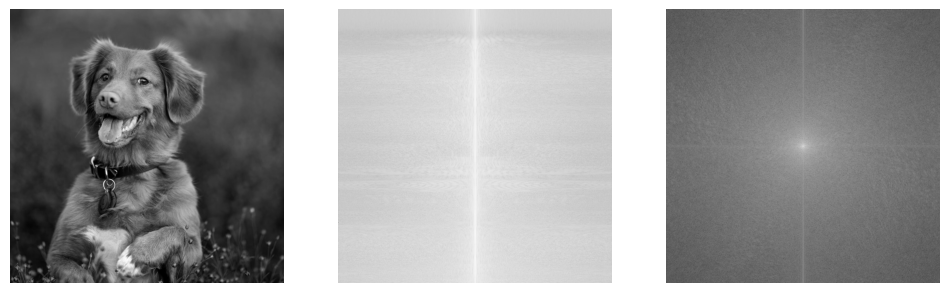

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size': 18})

fig,axs = plt.subplots(1,3)

img = axs[0].imshow(B)
img.set_cmap('gray')
axs[0].axis('off')

Cshift = np.zeros_like(B, dtype=complex)
C = np.zeros_like(B, dtype=complex)

for j in range(B.shape[0]):
    Cshift[j,:] = np.fft.fftshift(np.fft.fft(B[j,:]))
    C[j,:] = np.fft.fft(B[j,:])

img = axs[1].imshow(np.log(np.abs(Cshift)))
img.set_cmap('gray')
axs[1].axis('off')

D = np.zeros_like(C)
for j in range(C.shape[1]):
    D[:,j] = np.fft.fft(C[:,j])

img = axs[2].imshow(np.fft.fftshift(np.log(np.abs(D))))
img.set_cmap('gray')
axs[2].axis('off')

plt.show()

D = np.fft.fft2(B)

Testes usando FFT e mantendo apenas uma pequena fração das informações

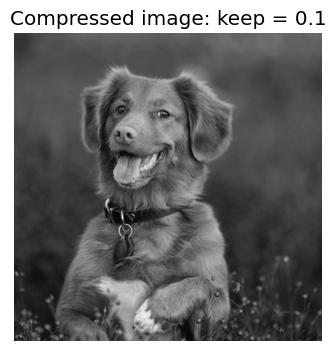

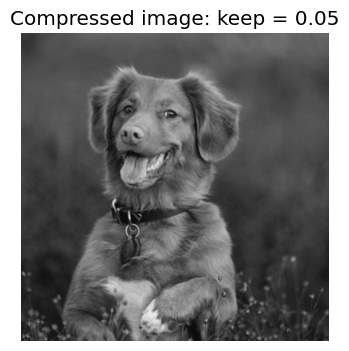

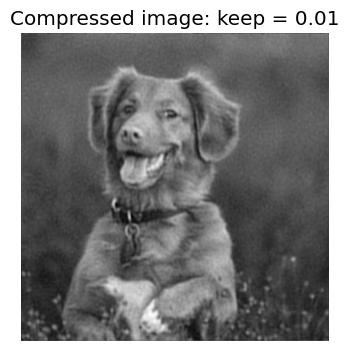

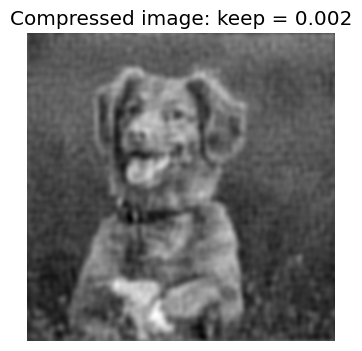

In [ ]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams.update({'font.size': 12})

Bt = np.fft.fft2(B)
Btsort = np.sort(np.abs(Bt.reshape(-1)))

for keep in (0.1, 0.05, 0.01, 0.002):
    thresh = Btsort[int(np.floor((1-keep)*len(Btsort)))]
    ind = np.abs(Bt)>thresh
    Atlow = Bt * ind
    Alow = np.fft.ifft2(Atlow).real
    plt.figure()
    plt.imshow(Alow,cmap='gray')
    plt.axis('off')
    plt.title('Compressed image: keep = ' + str(keep))

Testes adicionando (artificialmente) ruído na imagem

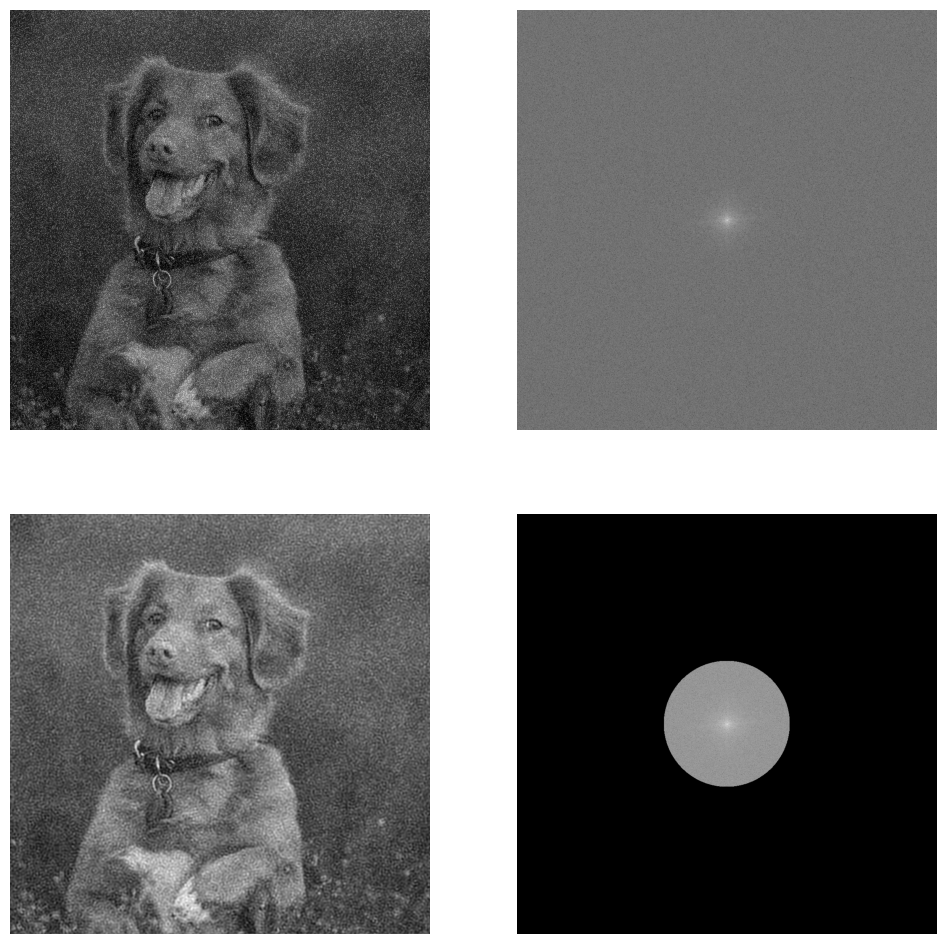

In [ ]:
plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams.update({'font.size': 12})

Bnoise = B + 200*np.random.randn(*B.shape).astype('uint8') # Add some noise
Bt = np.fft.fft2(Bnoise)
Btshift = np.fft.fftshift(Bt)
F = np.log(np.abs(Btshift)+1) # FFT log

fig,axs = plt.subplots(2,2)

axs[0,0].imshow(Bnoise,cmap='gray')
axs[0,0].axis('off')

axs[0,1].imshow(F,cmap='gray')
axs[0,1].axis('off')

nx,ny = B.shape
X,Y = np.meshgrid(np.arange(-ny/2+1,ny/2+1),np.arange(-nx/2+1,nx/2+1))
# xgrid = np.fft.ifftshift(np.arange(-nx/2+1,nx/2+1))
# ygrid = np.fft.ifftshift(np.arange(-ny/2+1,ny/2+1))
# X,Y = np.meshgrid(ygrid,xgrid)
R2 = np.power(X,2) + np.power(Y,2)
ind = R2 < 150**2
Btshiftfilt = Btshift * ind
Ffilt = np.log(np.abs(Btshiftfilt)+1) # FFT log

axs[1,1].imshow(Ffilt,cmap='gray')
axs[1,1].axis('off')

Btfilt = np.fft.ifftshift(Btshiftfilt)
Bfilt = np.fft.ifft2(Btfilt).real
axs[1,0].imshow(Bfilt,cmap='gray')
axs[1,0].axis('off')

plt.show()

Testes usando decomposição Wavelet

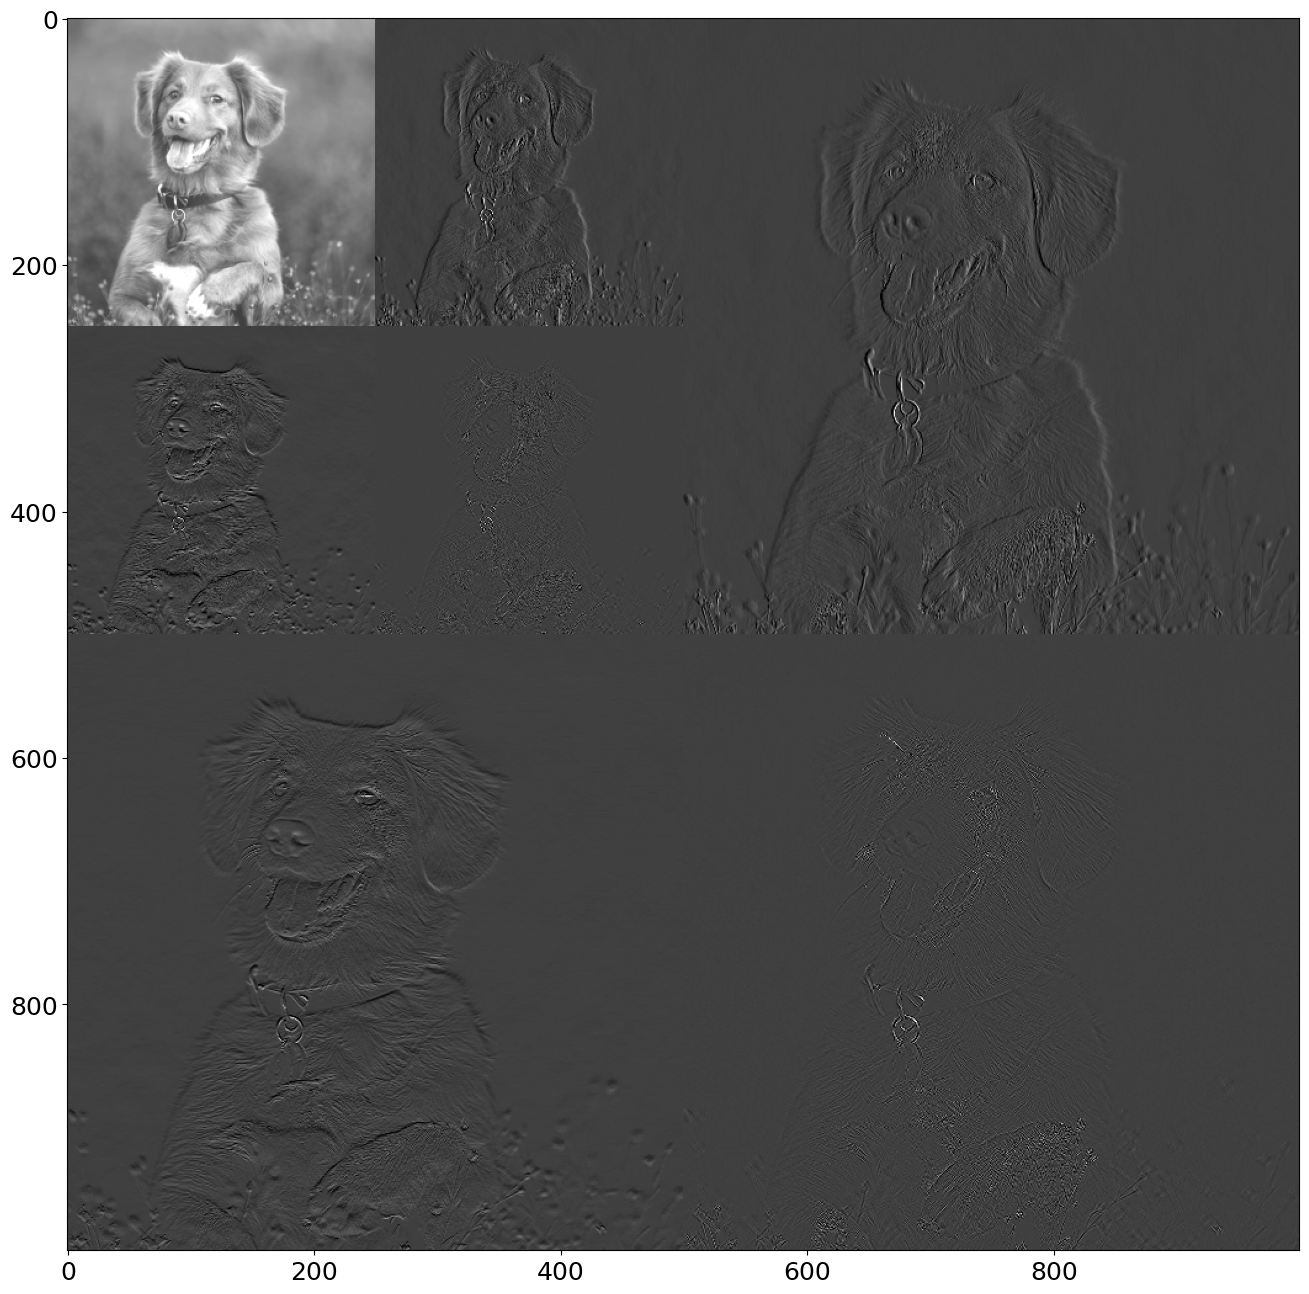

In [ ]:
plt.rcParams['figure.figsize'] = [16, 16]
plt.rcParams.update({'font.size': 18})

n = 2
w = 'db1'
coeffs = pywt.wavedec2(B,wavelet=w,level=n)

coeffs[0] /= np.abs(coeffs[0]).max()
for detail_level in range(n):
    coeffs[detail_level + 1] = [d/np.abs(d).max() for d in coeffs[detail_level + 1]]

arr, coeff_slices = pywt.coeffs_to_array(coeffs)

plt.imshow(arr,cmap='gray',vmin=-0.25,vmax=0.75)
plt.show()

Testes usando Wavelet e mantendo apenas uma pequena fração das informações

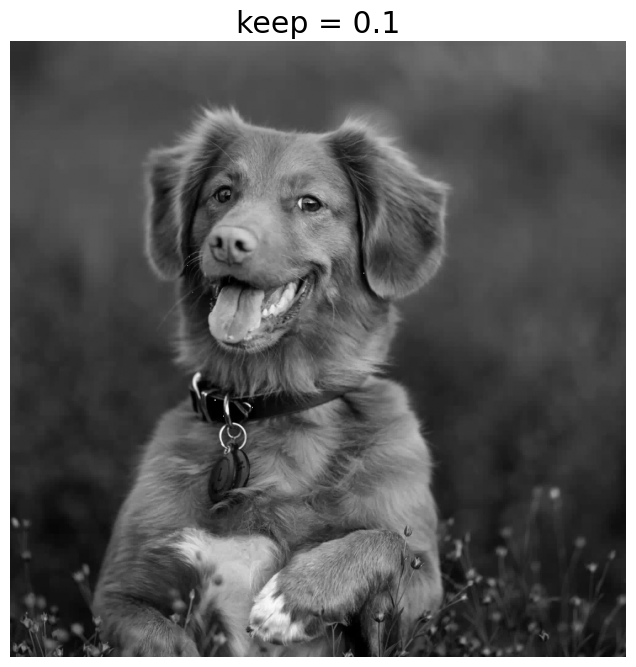

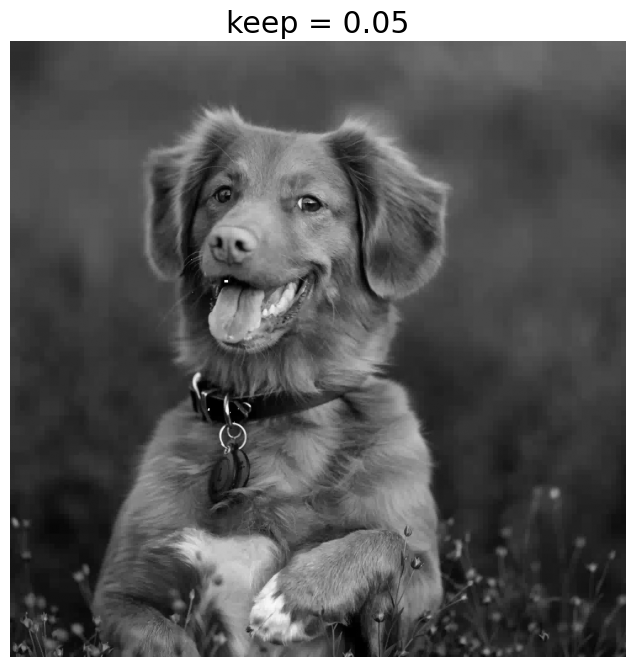

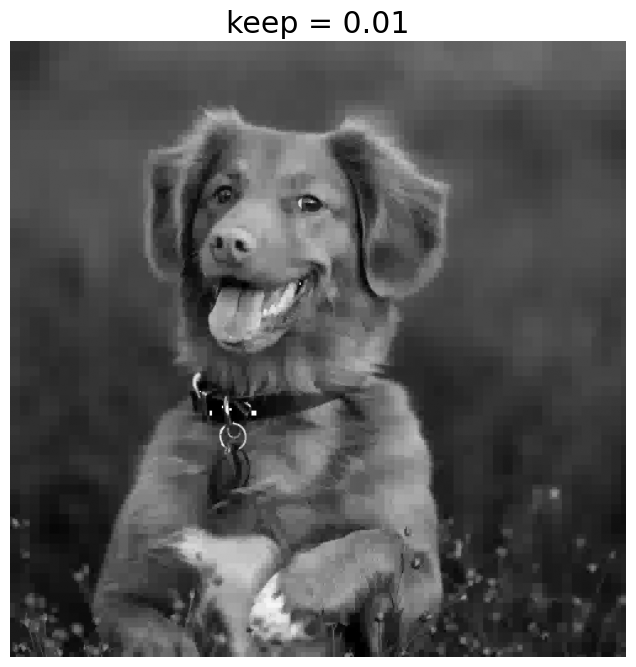

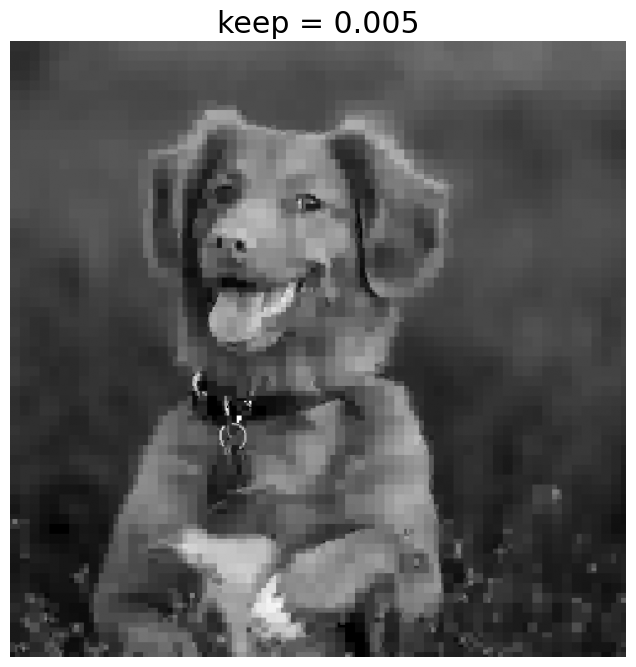

In [ ]:
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 18})

n = 4
w = 'db1'
coeffs = pywt.wavedec2(B,wavelet=w,level=n)

coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)

Csort = np.sort(np.abs(coeff_arr.reshape(-1)))

for keep in (0.1, 0.05, 0.01, 0.005):
    thresh = Csort[int(np.floor((1-keep)*len(Csort)))]
    ind = np.abs(coeff_arr) > thresh
    Cfilt = coeff_arr * ind # Threshold small indices

    coeffs_filt = pywt.array_to_coeffs(Cfilt,coeff_slices,output_format='wavedec2')

    # Plot reconstruction
    Arecon = pywt.waverec2(coeffs_filt,wavelet=w)
    plt.figure()
    plt.imshow(Arecon.astype('uint8'),cmap='gray')
    plt.axis('off')
    plt.title('keep = ' + str(keep))